In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib widget

In [2]:
T = 2 # seconds
dt= 0.001 # time step in seconds
t = np.arange(0, T, dt)
freq = 20 #Hz
ipi = 1/freq/dt # in units of time steps
num_spikes = 10
train_start = 0.5 #seconds

presyn_train = np.zeros(int(T/dt) )
spike_times = []
for i in range(num_spikes):
    spike_times.append(int((train_start/dt)+ipi*i))
presyn_train[spike_times] = 1.0

In [3]:
spike_times

[500, 550, 600, 650, 700, 750, 800, 850, 900, 950]

In [4]:
# Define the system of differential equations
def ode_system(y, t, params, presyn_train, spike_times):
    # Extract parameters from the input tuple
    1
    # a, b, c, U_baseline, U_increment, U_decay_rate, V_baseline, V_increment, V_decay_rate = params
    tau_r, p, n, tau_f, p0, a_f = params
    
    # Unpack the state variables
    # x, y, z, U, V = y
    p, n = y
    
    # Compute the current input to the system based on the presynaptic activity
    input_current = presyn_train #np.interp(t, np.arange(0, T, dt), presyn_train) #np.interp(t, spike_times, presyn_train)
    
    # Define the differential equations
    # dxdt = a*(y - x) - U*x
    # dydt = x*(b - z) - y + V*input_current
    # dzdt = x*y - c*z
    # dUdt = U_increment*input_current - U_decay_rate*U
    # dVdt = V_increment*(1 - V*input_current) - V_decay_rate*V
    dpdt = ((p0 - p)/tau_f) + input_current* a_f* (1-p)
    dndt = ((1- n)/tau_r) + input_current* p * n
    
    # Pack the results into a numpy array
    dydt_vec = np.array([dpdt, dndt])
    
    print(dydt_vec.shape)
    return dydt_vec




# Integrate the system of equations
sol = odeint(ode_system, y0, t, args=(params, presyn_train, spike_times))

In [5]:
# Set the initial conditions and parameters
y0 = [0.2, 1.0]
params = (10, 0.2, 1.0, 5, 0.2, 0.05)



In [6]:
# Set the time range for integration
T = 1.0 # seconds
dt = 0.001 # time step in seconds


# Set the presynaptic activity
freq = 20 #Hz


print(len(t), len(spike_times), len(presyn_train))

2000 10 2000


In [38]:
def STP_model(freq, spike_train='', p0 = 0.2, tau_f = 100, a_f = 0.1, tau_r = 40, g_max = 10, train_start=0.2, num_spikes=10, T=10.0, dt=0.001, plot_traces=True):
    

    t = np.arange(0, T, dt)
    
    if freq != 0:
        # print('using freq')
        ipi = 1/freq/dt # in units of time steps
        presyn_train = np.zeros(len(t))
        
        spike_times = []
        for i in range(num_spikes):
            spike_time = int(train_start/dt + ipi*i)
            spike_times.append(spike_time)
            presyn_train[spike_time] = 1.0
    else:
        print('using given spike train')
        presyn_train = spike_train
        print(len(t), len(presyn_train))
        T = len(spike_train)*dt
        t = np.arange(0,T, dt)

    p = p0
    n = 1
    pt = 0*presyn_train
    nt = 0*presyn_train

    for i,tt in enumerate(t):
        dpdt = ((p0 - p)/tau_f) + a_f * (1-p) * presyn_train[i]
        # print(a_f * (1-p) * presyn_train[i])
        p += dpdt

        dndt = ((1-n)/tau_r) - p * n * presyn_train[i]

        n += dndt

        pt[i] = p
        nt[i] = n

    gt = g_max * np.multiply(pt,nt)
    
    
    if plot_traces:
        plt.figure()
        plt.plot(t,nt, label='n(t)')
        plt.plot(t,pt, label='p(t)')
        plt.plot(t,gt, label='g(t)')
        plt.legend()
        
    if freq != 0:
        stpr = STPR(gt, spike_times, ipi)
        ppr = PPR(gt, spike_times, ipi)
    else:
        stpr, ppr = None, None
    
    return [pt, nt, gt, stpr, ppr, presyn_train]


In [8]:
def STPR(gt, t_spikes, ipi):
    g1 = np.max(gt[t_spikes[0]:t_spikes[0]+int(ipi)])
    
    glast3 = np.average([gt[t_spikes[-1]:t_spikes[-1]+int(ipi)],
                        gt[t_spikes[-2]:t_spikes[-2]+int(ipi)],
                        gt[t_spikes[-3]:t_spikes[-3]+int(ipi)]])
    
    return glast3/g1

def PPR(gt, t_spikes, ipi):
    g1 = np.max(gt[t_spikes[0]:t_spikes[0]+int(ipi)])
    
    g2 = np.max(gt[t_spikes[1]:t_spikes[1]+int(ipi)])
    
    return g2/g1


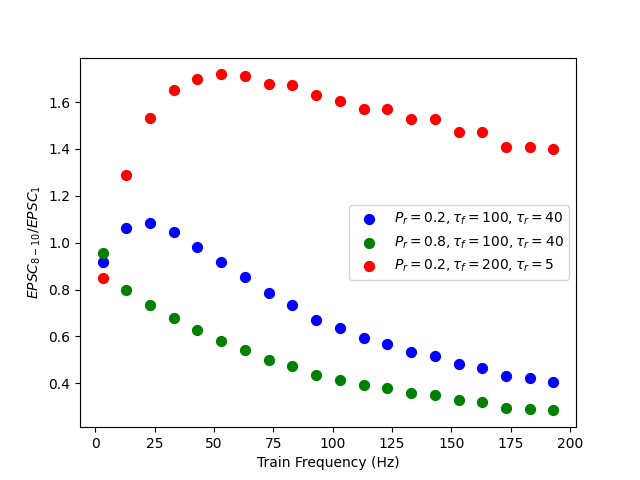

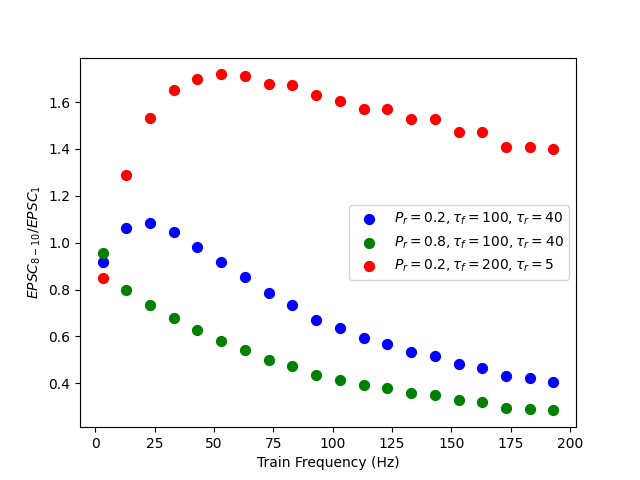

In [9]:
fig1 , ax1 = plt.subplots()
for f in range(2,200, 10):
    _,_,_,stpr_lowpr,_,_   = STP_model(f, plot_traces=False, p0=0.2, tau_f = 100)
    _,_,_,stpr_highpr,_,_ = STP_model(f, plot_traces=False, p0=0.6, tau_f = 100)
    _,_,_,stpr_tauflip,_,_ = STP_model(f, plot_traces=False, p0=0.2, tau_f=200, tau_r = 5, a_f = 0.1)
    
    plt.scatter(f+1, stpr_lowpr, 50, 'b', label='Pr = 0.2, /tau_f = 100, /tau_r = 40')
    plt.scatter(f+1, stpr_highpr, 50, 'g', label='Pr = 0.8, /tau_f = 100, /tau_r = 40')
    plt.scatter(f+1, stpr_tauflip, 50, 'r', label='Pr = 0.2, /tau_f = 200, /tau_r = 5')
    
ax1.set_xlabel('Train Frequency (Hz)')
ax1.set_ylabel(r'$EPSC_{8-10} / EPSC_1$')
ax1.legend([r'$P_r = 0.2, \tau_f = 100, \tau_r = 40$', r'$P_r = 0.8, \tau_f = 100, \tau_r = 40$', r'$P_r = 0.2, \tau_f = 200, \tau_r = 5$'])
fig1.show()

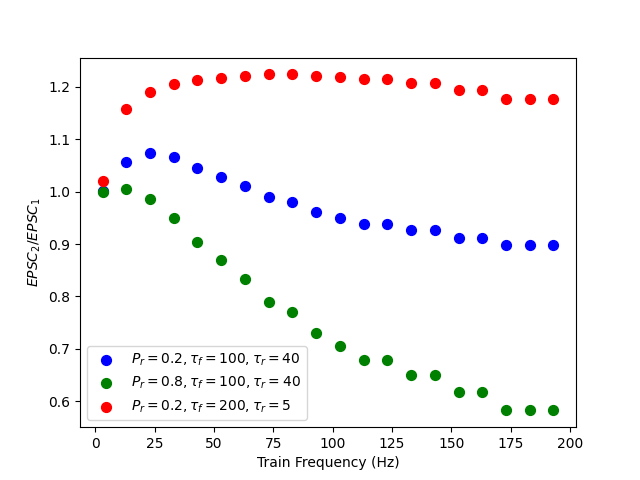

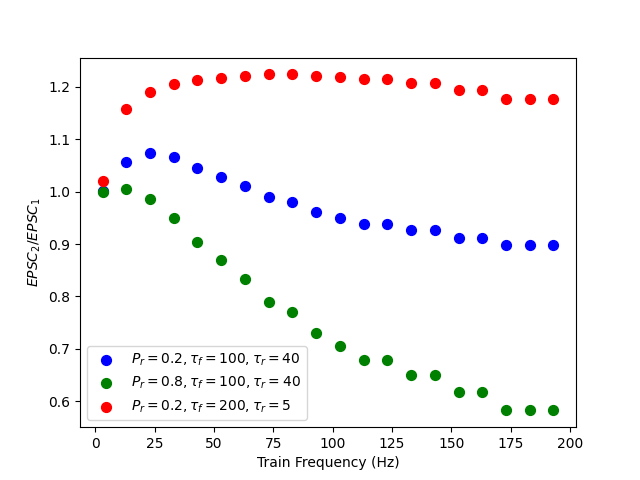

In [10]:
fig2, ax2 = plt.subplots()
for f in range(2,200, 10):
    _,_,_,_,ppr_lowpr,_   = STP_model(f, plot_traces=False, p0=0.2, tau_f = 100)
    _,_,_,_,ppr_highpr,_ = STP_model(f, plot_traces=False, p0=0.6, tau_f = 100)
    _,_,_,_,ppr_tauflip,_ = STP_model(f, plot_traces=False, p0=0.2, tau_f=200, tau_r = 5, a_f = 0.1)
    
    plt.scatter(f+1, ppr_lowpr, 50, 'b', label='Pr = 0.2, /tau_f = 100, /tau_r = 40')
    plt.scatter(f+1, ppr_highpr, 50, 'g', label='Pr = 0.8, /tau_f = 100, /tau_r = 40')
    plt.scatter(f+1, ppr_tauflip, 50, 'r', label='Pr = 0.2, /tau_f = 200, /tau_r = 5')
    
ax2.set_xlabel('Train Frequency (Hz)')
ax2.set_ylabel(r'$EPSC_2 / EPSC_1$')
ax2.legend([r'$P_r = 0.2, \tau_f = 100, \tau_r = 40$', r'$P_r = 0.8, \tau_f = 100, \tau_r = 40$', r'$P_r = 0.2, \tau_f = 200, \tau_r = 5$'])
fig2.show()

In [11]:
epsc20 = STP_model(20, p0=0.2 , tau_f= 200, tau_r= 5, a_f= 0.1, g_max=10, plot_traces=False) # facilitation, weak synapses
ipsc20 = STP_model(20, p0=0.8 , tau_f= 60, tau_r= 40, a_f= 0.1, g_max=20, plot_traces=False) # depressing, but strong synapses

### $\tau\frac{dV}{dt} = -(V - V_{rest}) + g(E - V)$

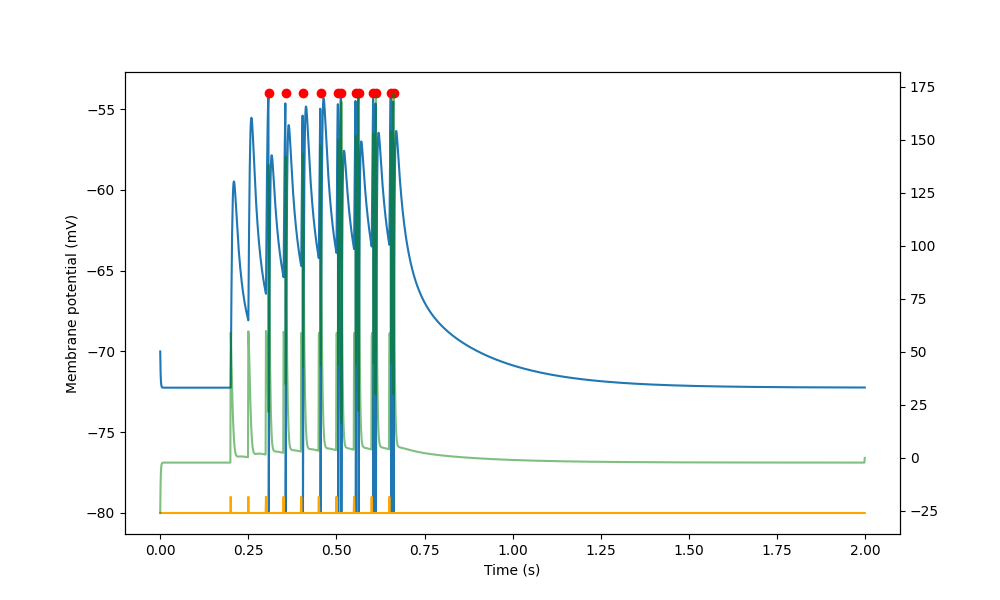

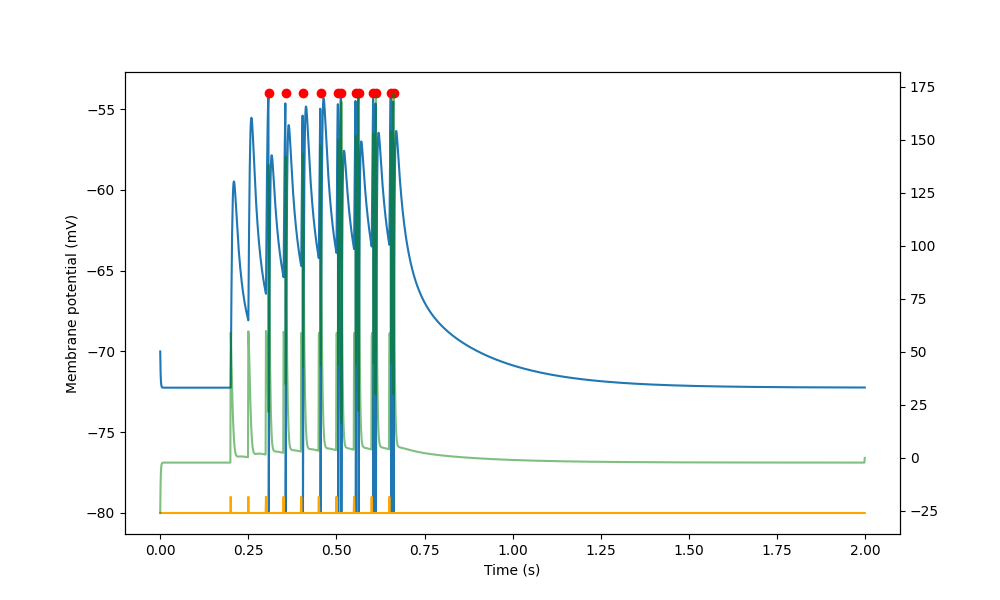

In [12]:
# LIF
ge = epsc20[2]
gi = ipsc20[2]
spike_train_pre = epsc20[-1][:2000]
# spike_train_pre = spike_train

# Define simulation parameters
T = 2.0  # simulation duration (seconds)
dt = 0.001  # time step (seconds)
tau = 0.02  # membrane time constant (seconds)
Vrest = -70  # resting potential (mV)
Vth = -54  # spike threshold (mV)
Vreset = -80  # reset potential (mV)
Rm = 1e8
Cm = 2e-10

# Define current sources and their reversal potentials
Ereve = 0  # reversal potential (mV)
Erevi = -80  # reversal potential (mV)

# Calculate simulation variables
num_steps = int(T / dt)
time = np.arange(num_steps) * dt
membrane_potential = np.zeros(num_steps)
membrane_potential[0] = Vrest
spike_times_post = []
Isyn = np.zeros(num_steps)
# Run simulation
for i in range(1, num_steps):
    # Calculate current input to the neuron
    Ie = 0.5*ge[i-1] * ( Ereve - membrane_potential[i-1])
    Ii = 0.6*gi[i-1] * ( Erevi - membrane_potential[i-1])
    
    Isyn[i-1] = Ie + Ii
    
    # Update membrane potential
    dvdt = (-membrane_potential[i - 1] + Vrest + Ie + Ii) / tau
    membrane_potential[i] = membrane_potential[i - 1] + dvdt * dt

    # Check for spike
    if membrane_potential[i] > Vth:
        spike_times_post.append(time[i])
        membrane_potential[i] = Vreset

# Plot results
fig4, ax4 = plt.subplots(figsize=(10,6))
ax42 = ax4.twinx()
ax42.plot(time, Isyn, 'g', alpha=0.5)

ax4.plot(time, membrane_potential)
ax4.plot(time, -80+spike_train_pre, 'orange') 

ax4.plot(spike_times_post, np.ones(len(spike_times_post)) * Vth, 'ro')

ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Membrane potential (mV)')
fig4.show()


In [13]:
from eidynamics import utils

In [14]:
train = utils.poisson_train(20, 1, 10, firing_rate_high_cutoff=100, time_step=0.1, Fs=1e3, plot_raster=False)

In [15]:
spike_train = train[0]
isis = train[2]

In [47]:
spike_test = np.linspace(0,0.1, 100)
spike_test[20] = 1.0
spike_test[40] = 1.0

In [48]:
epsc_train = STP_model(0, spike_train=spike_test, p0 = 0.2, tau_f = 200, a_f = 0.1, tau_r = 5, g_max = 10, train_start=0.2, num_spikes=10, T=10.0, dt=0.001, plot_traces=False)
ipsc_train = STP_model(0, spike_train=spike_test, p0 = 0.8 ,tau_f= 100, tau_r= 40, a_f= 0.1, g_max=20, plot_traces=False)

using given spike train
10000 100
using given spike train
10000 100


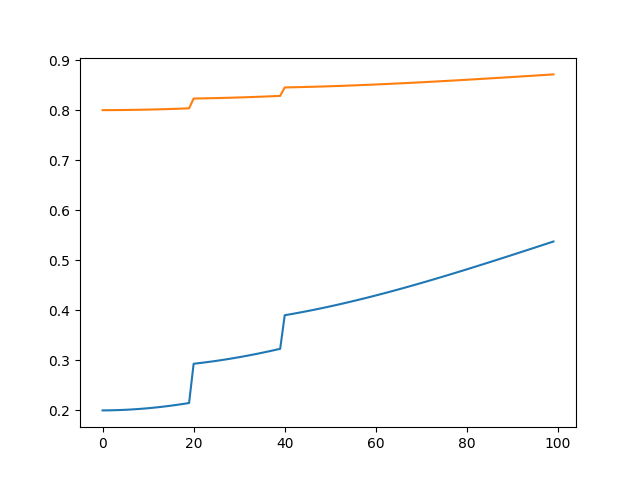

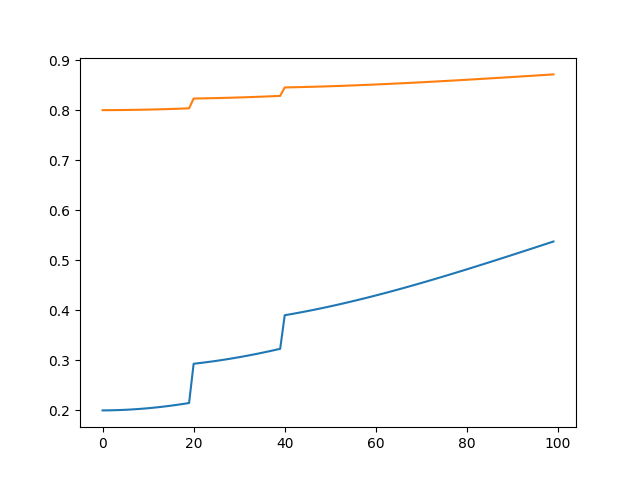

In [49]:
fig6, ax6 = plt.subplots()
ax6.plot(epsc_train[0])
ax6.plot(ipsc_train[0])
fig6.show()

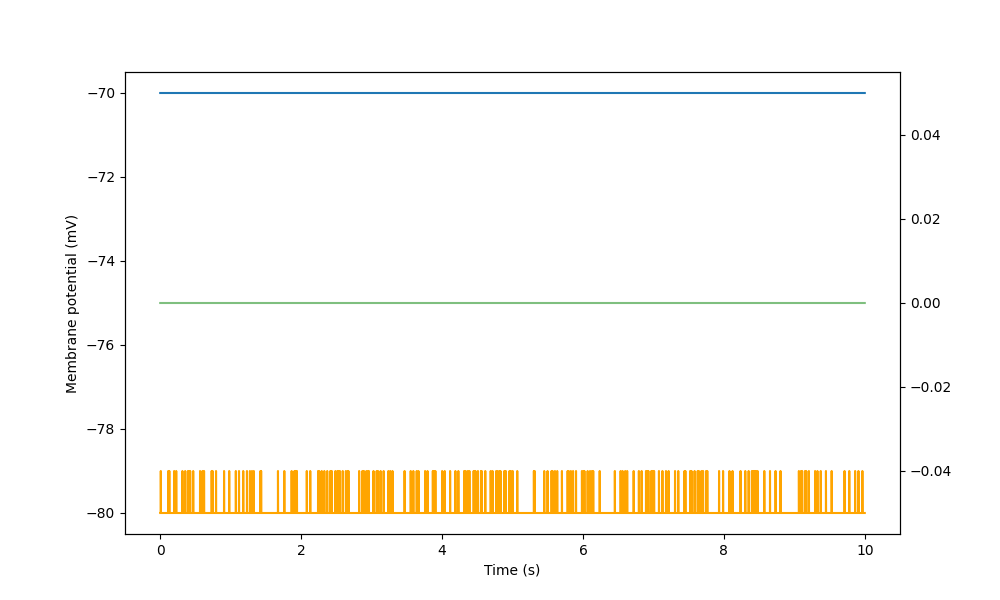

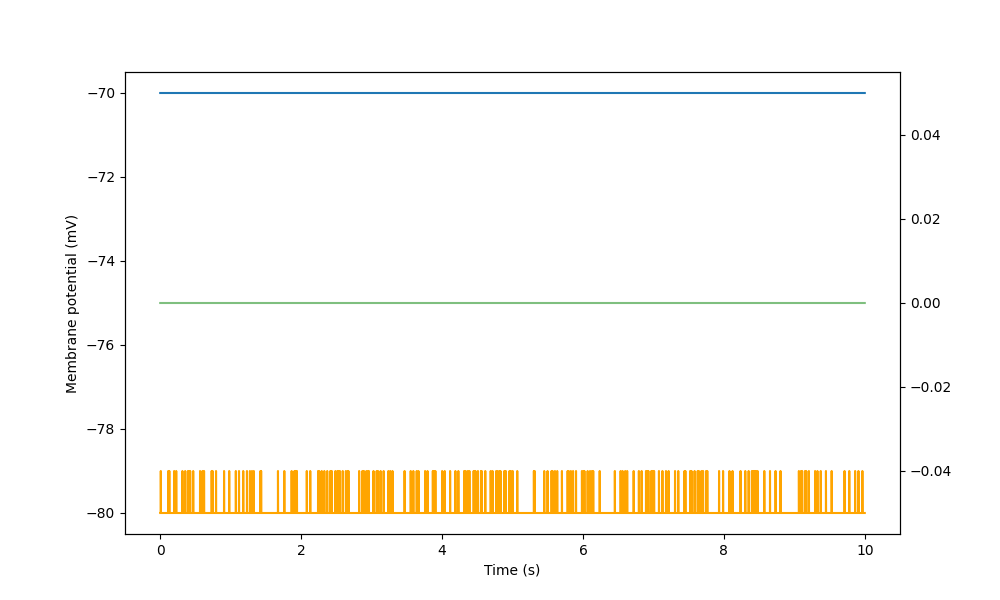

In [33]:
# LIF
ge = epsc_train[2]
gi = ipsc_train[2]
# spike_train_pre = epsc20[-1][:2000]
spike_train_pre = spike_train

# Define simulation parameters
T = 10.0  # simulation duration (seconds)
dt = 0.001  # time step (seconds)
tau = 0.02  # membrane time constant (seconds)
Vrest = -70  # resting potential (mV)
Vth = -54  # spike threshold (mV)
Vreset = -80  # reset potential (mV)
Rm = 1e8
Cm = 2e-10

# Define current sources and their reversal potentials
Ereve = 0  # reversal potential (mV)
Erevi = -80  # reversal potential (mV)

# Calculate simulation variables
num_steps = int(T / dt)
time = np.arange(num_steps) * dt
membrane_potential = np.zeros(num_steps)
membrane_potential[0] = Vrest
spike_times_post = []
Isyn = np.zeros(num_steps)
# Run simulation
for i in range(1, num_steps):
    # Calculate current input to the neuron
    Ie = 0.5*ge[i-1] * ( Ereve - membrane_potential[i-1])
    Ii = 0.6*gi[i-1] * ( Erevi - membrane_potential[i-1])
    
    Isyn[i-1] = Ie + Ii
    
    # Update membrane potential
    dvdt = (-membrane_potential[i - 1] + Vrest + Ie + Ii) / tau
    membrane_potential[i] = membrane_potential[i - 1] + dvdt * dt

    # Check for spike
    if membrane_potential[i] > Vth:
        spike_times_post.append(time[i])
        membrane_potential[i] = Vreset

# Plot results
fig4, ax4 = plt.subplots(figsize=(10,6))
ax42 = ax4.twinx()
ax42.plot(time, Isyn, 'g', alpha=0.5)

ax4.plot(time, membrane_potential)
ax4.plot(time, -80+spike_train_pre, 'orange') 

ax4.plot(spike_times_post, np.ones(len(spike_times_post)) * Vth, 'ro')

ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Membrane potential (mV)')
fig4.show()
